# **Initialization**

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import missingno as msno

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor

import joblib

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
x_train_file = '/content/drive/MyDrive/x-train.npy'
y_train_file = '/content/drive/MyDrive/y-train.npy'
x_test_file = '/content/drive/MyDrive/x-test.npy'
y_test_file = '/content/drive/MyDrive/y-test.npy'
model_file = '/content/drive/MyDrive/model.pkl'

# **Data**

## **Load Data**


**Dataset:** [California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

In [121]:
# df = pd.read_csv(kagglehub.dataset_download("camnugent/california-housing-prices") + "/housing.csv")
# df_train, df_test = train_test_split(df, shuffle=True, test_size=0.2)
# df_train.to_csv('/content/drive/MyDrive/chp-train.csv', index=False)
# df_test.to_csv('/content/drive/MyDrive/chp-test.csv', index=False)

In [122]:
df = pd.read_csv('/content/drive/MyDrive/chp-train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/chp-test.csv')

In [123]:
print(df.shape)
df.head()

(16512, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.42,37.74,52.0,2084.0,550.0,1438.0,516.0,2.3087,258600.0,NEAR BAY
1,-118.30,34.00,52.0,1743.0,421.0,1206.0,384.0,1.6875,116000.0,<1H OCEAN
2,-117.96,34.48,32.0,1896.0,342.0,806.0,299.0,4.5769,159400.0,INLAND
3,-119.64,36.56,34.0,576.0,117.0,363.0,97.0,2.0658,92500.0,INLAND
4,-122.59,38.01,35.0,8814.0,1307.0,3450.0,1258.0,6.1724,414300.0,NEAR BAY


In [124]:
df.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,object


## **Missing values**

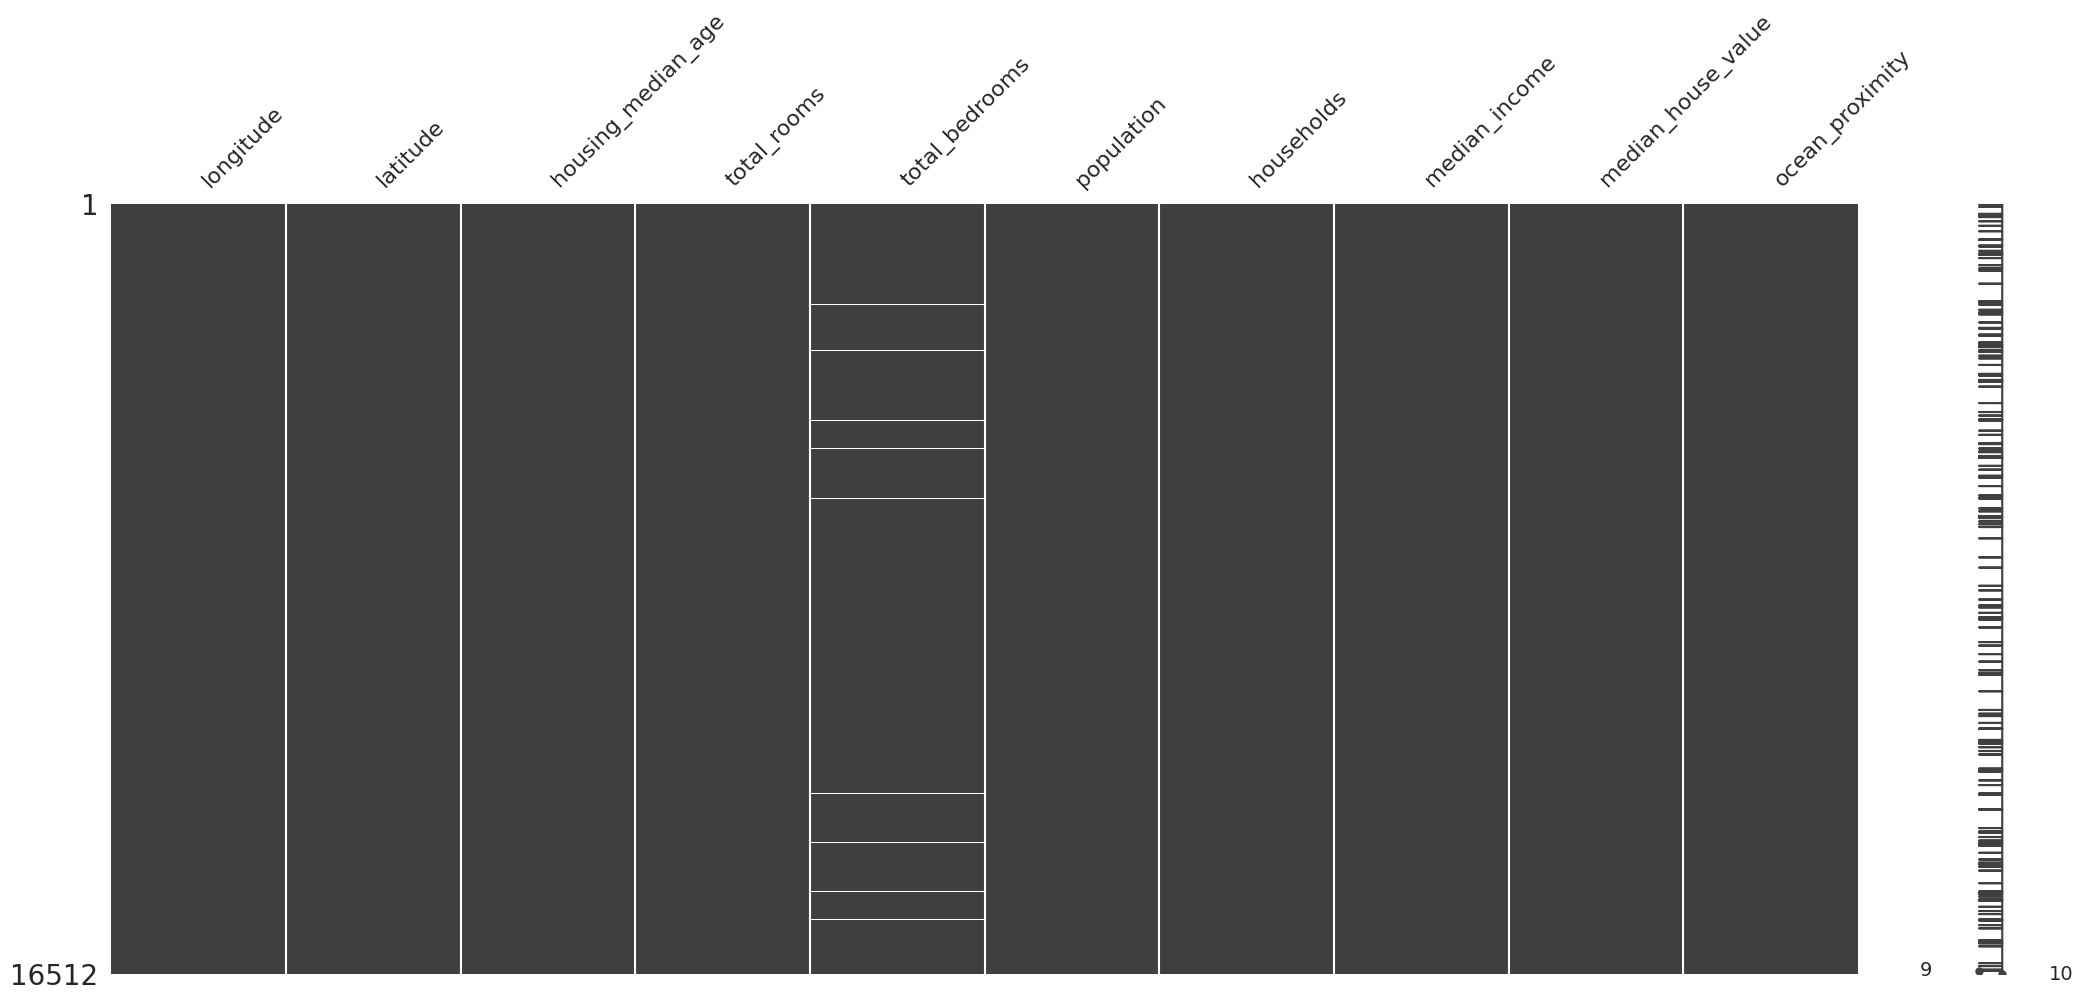

In [125]:
msno.matrix(df);

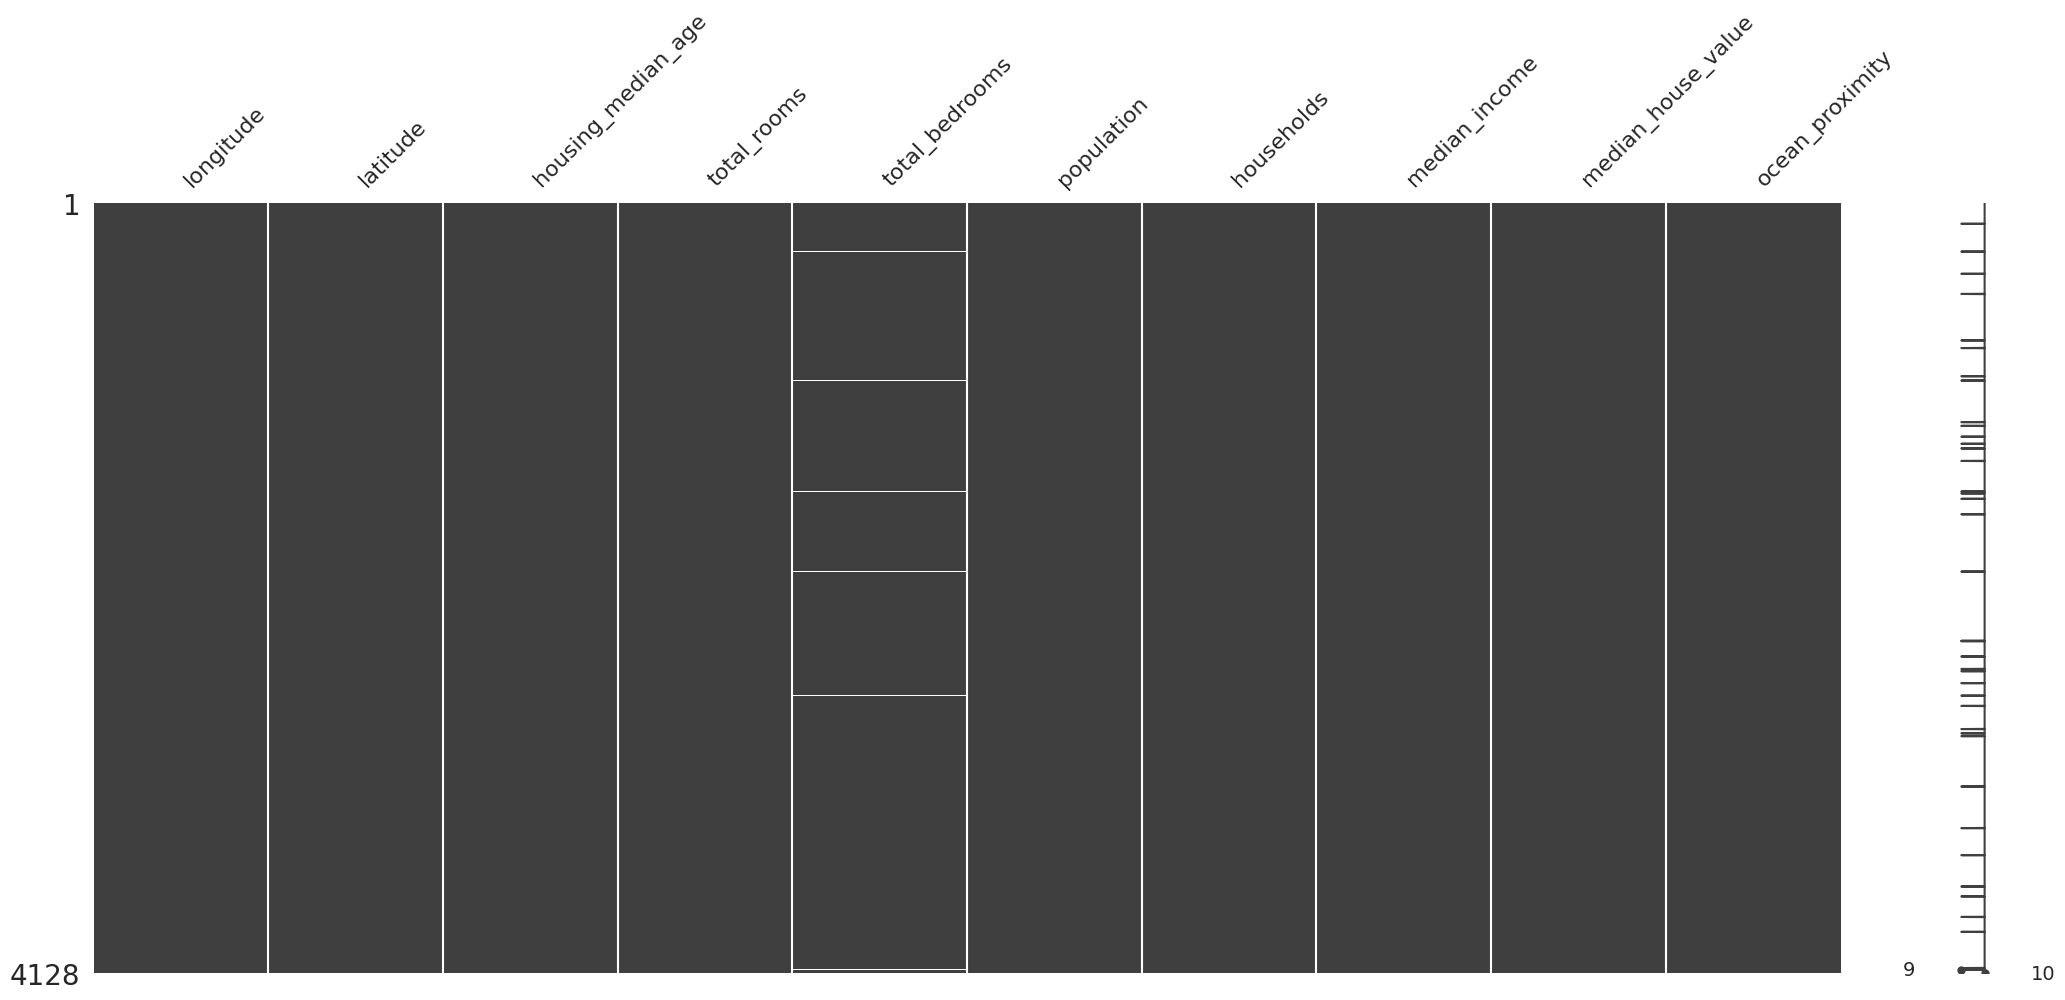

In [126]:
msno.matrix(test_df);

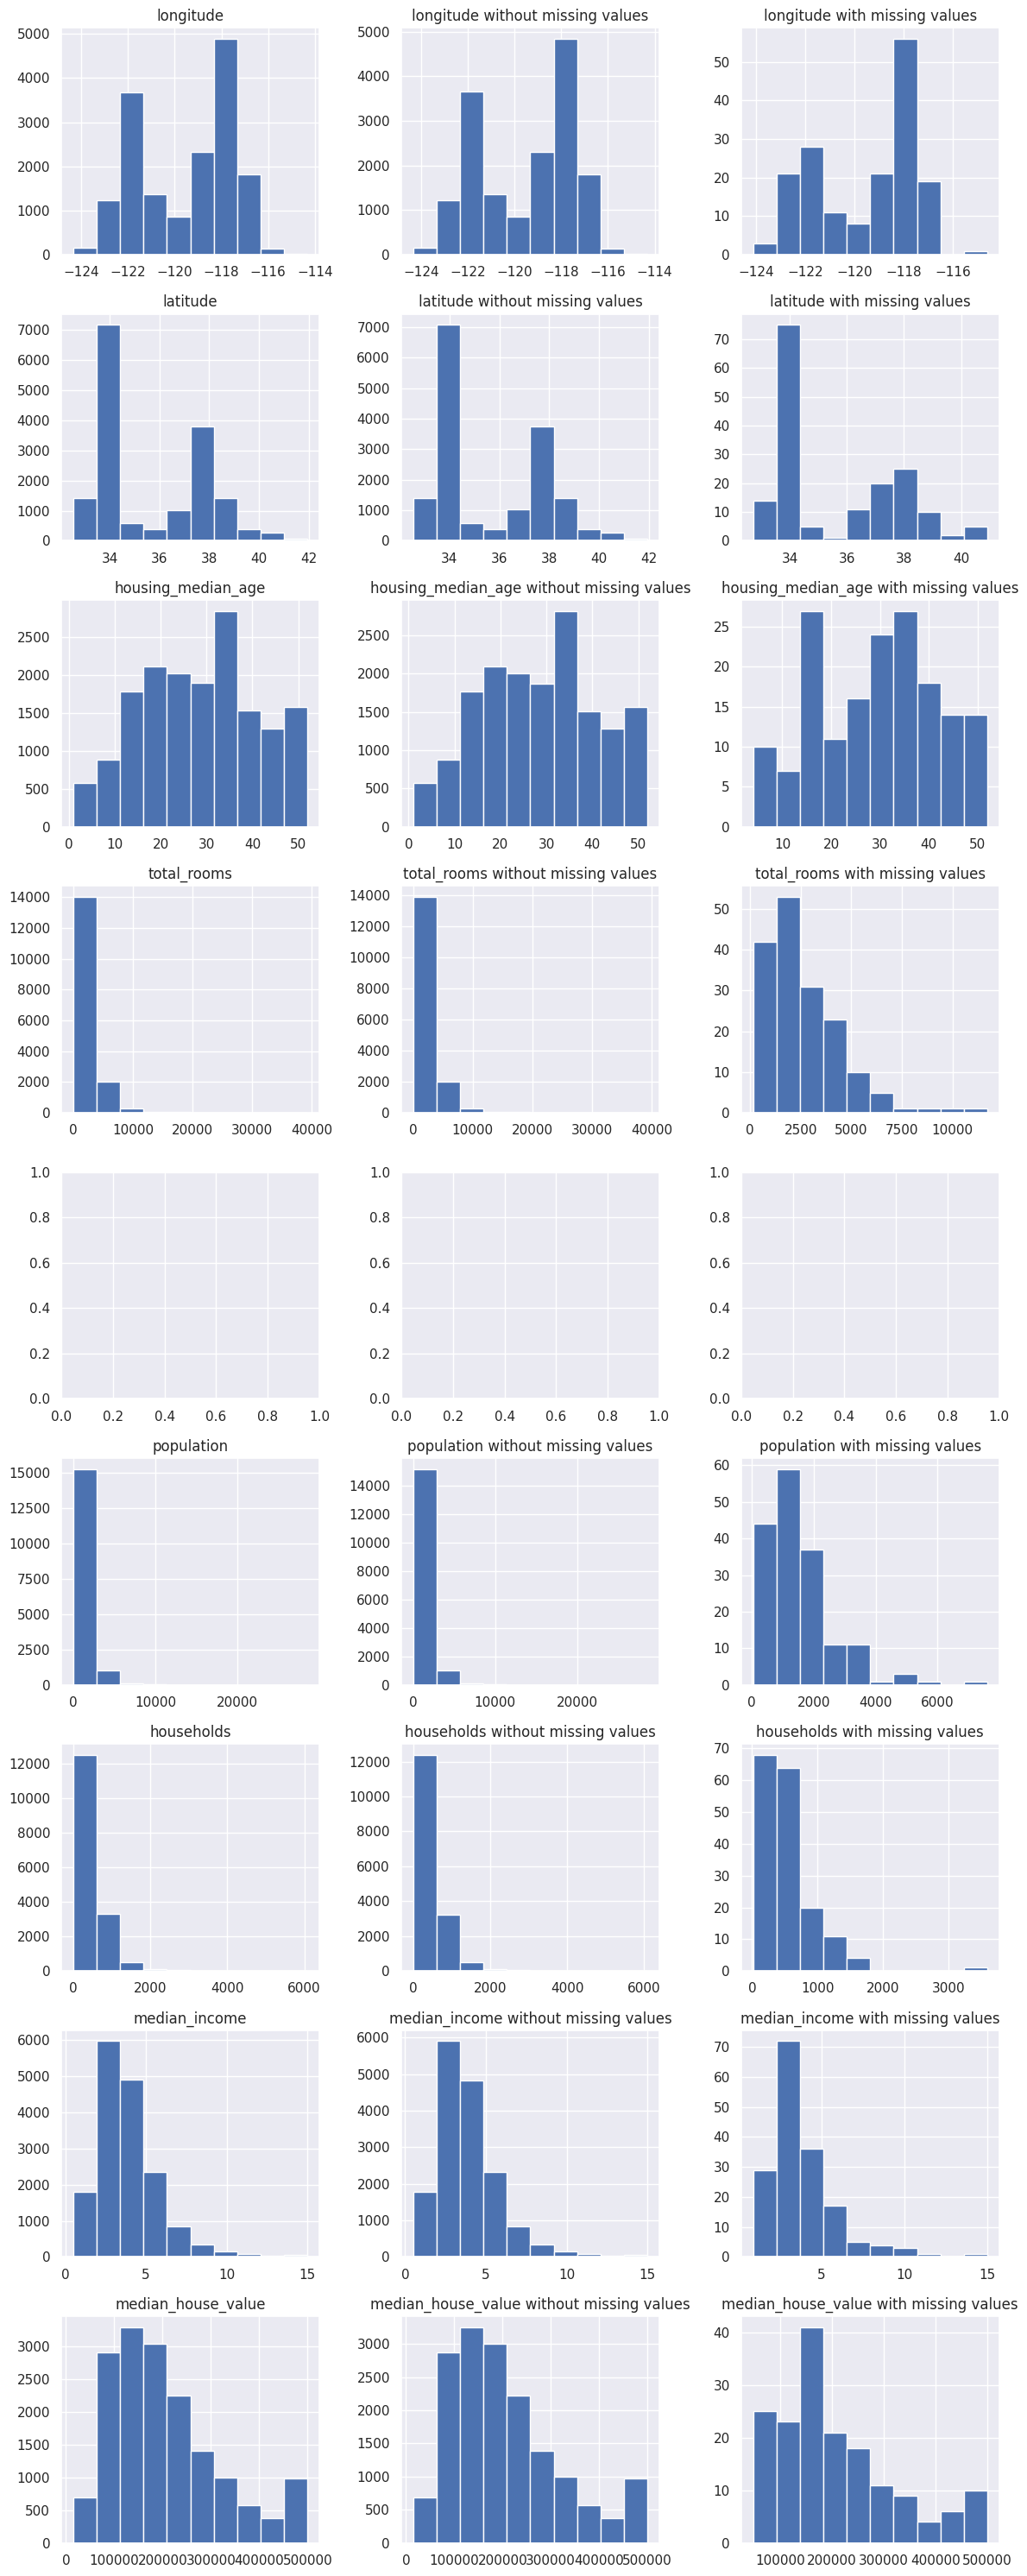

In [127]:
df_not_missing = df.dropna()
df_missing = df.drop(df_not_missing.index)

fig, ax = plt.subplots(len(df.columns) - 1, 3, figsize=(12, 30))
for i, col in enumerate(df.columns[:-1]):
    if col == 'total_bedrooms':
        continue
    ax[i, 0].hist(df[col])
    ax[i, 0].set_title(col)
    ax[i, 1].hist(df_not_missing[col])
    ax[i, 1].set_title(f'{col} without missing values')
    ax[i, 2].hist(df_missing[col])
    ax[i, 2].set_title(f'{col} with missing values')

plt.tight_layout()
plt.show()

In [128]:
median_total_bedrooms = df.total_bedrooms.median()
df.total_bedrooms = df.total_bedrooms.fillna(median_total_bedrooms)
df_test.total_bedrooms = df_test.total_bedrooms.fillna(median_total_bedrooms)

## **Encoding**

In [129]:
df = pd.get_dummies(df, columns=['ocean_proximity'], dtype=np.float64)
df_test = pd.get_dummies(df_test, columns=['ocean_proximity'], dtype=np.float64)

In [130]:
df.rename(columns={
    'ocean_proximity_<1H OCEAN': 'ocean_proximity_less_than_1H_OCEAN',
    'ocean_proximity_INLAND': 'ocean_proximity_inland',
    'ocean_proximity_NEAR OCEAN': 'ocean_proximity_near_ocean',
    'ocean_proximity_NEAR BAY': 'ocean_proximity_near_bay',
    'ocean_proximity_ISLAND': 'ocean_proximity_island',
}, inplace=True)
df_test.rename(columns={
    'ocean_proximity_<1H OCEAN': 'ocean_proximity_less_than_1H_OCEAN',
    'ocean_proximity_INLAND': 'ocean_proximity_inland',
    'ocean_proximity_NEAR OCEAN': 'ocean_proximity_near_ocean',
    'ocean_proximity_NEAR BAY': 'ocean_proximity_near_bay',
    'ocean_proximity_ISLAND': 'ocean_proximity_island',
}, inplace=True)

## **EDA**

In [131]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_less_than_1H_OCEAN,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
count,16512.00000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.57970,35.644284,28.654251,2626.682049,533.352168,1419.298813,496.662306,3.865183,206167.548631,0.440468,0.318556,0.000303,0.113190,0.127483
std,2.00502,2.139385,12.587373,2189.286815,415.161150,1112.195548,378.486283,1.906944,114981.880802,0.496458,0.465931,0.017399,0.316835,0.333523
min,-124.35000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.80000,33.940000,18.000000,1440.000000,296.000000,785.000000,279.000000,2.560000,119475.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.51000,34.260000,29.000000,2115.000000,433.000000,1163.000000,408.000000,3.528800,179200.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.01000,37.720000,37.000000,3129.250000,640.000000,1717.250000,601.000000,4.725400,263800.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.31000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


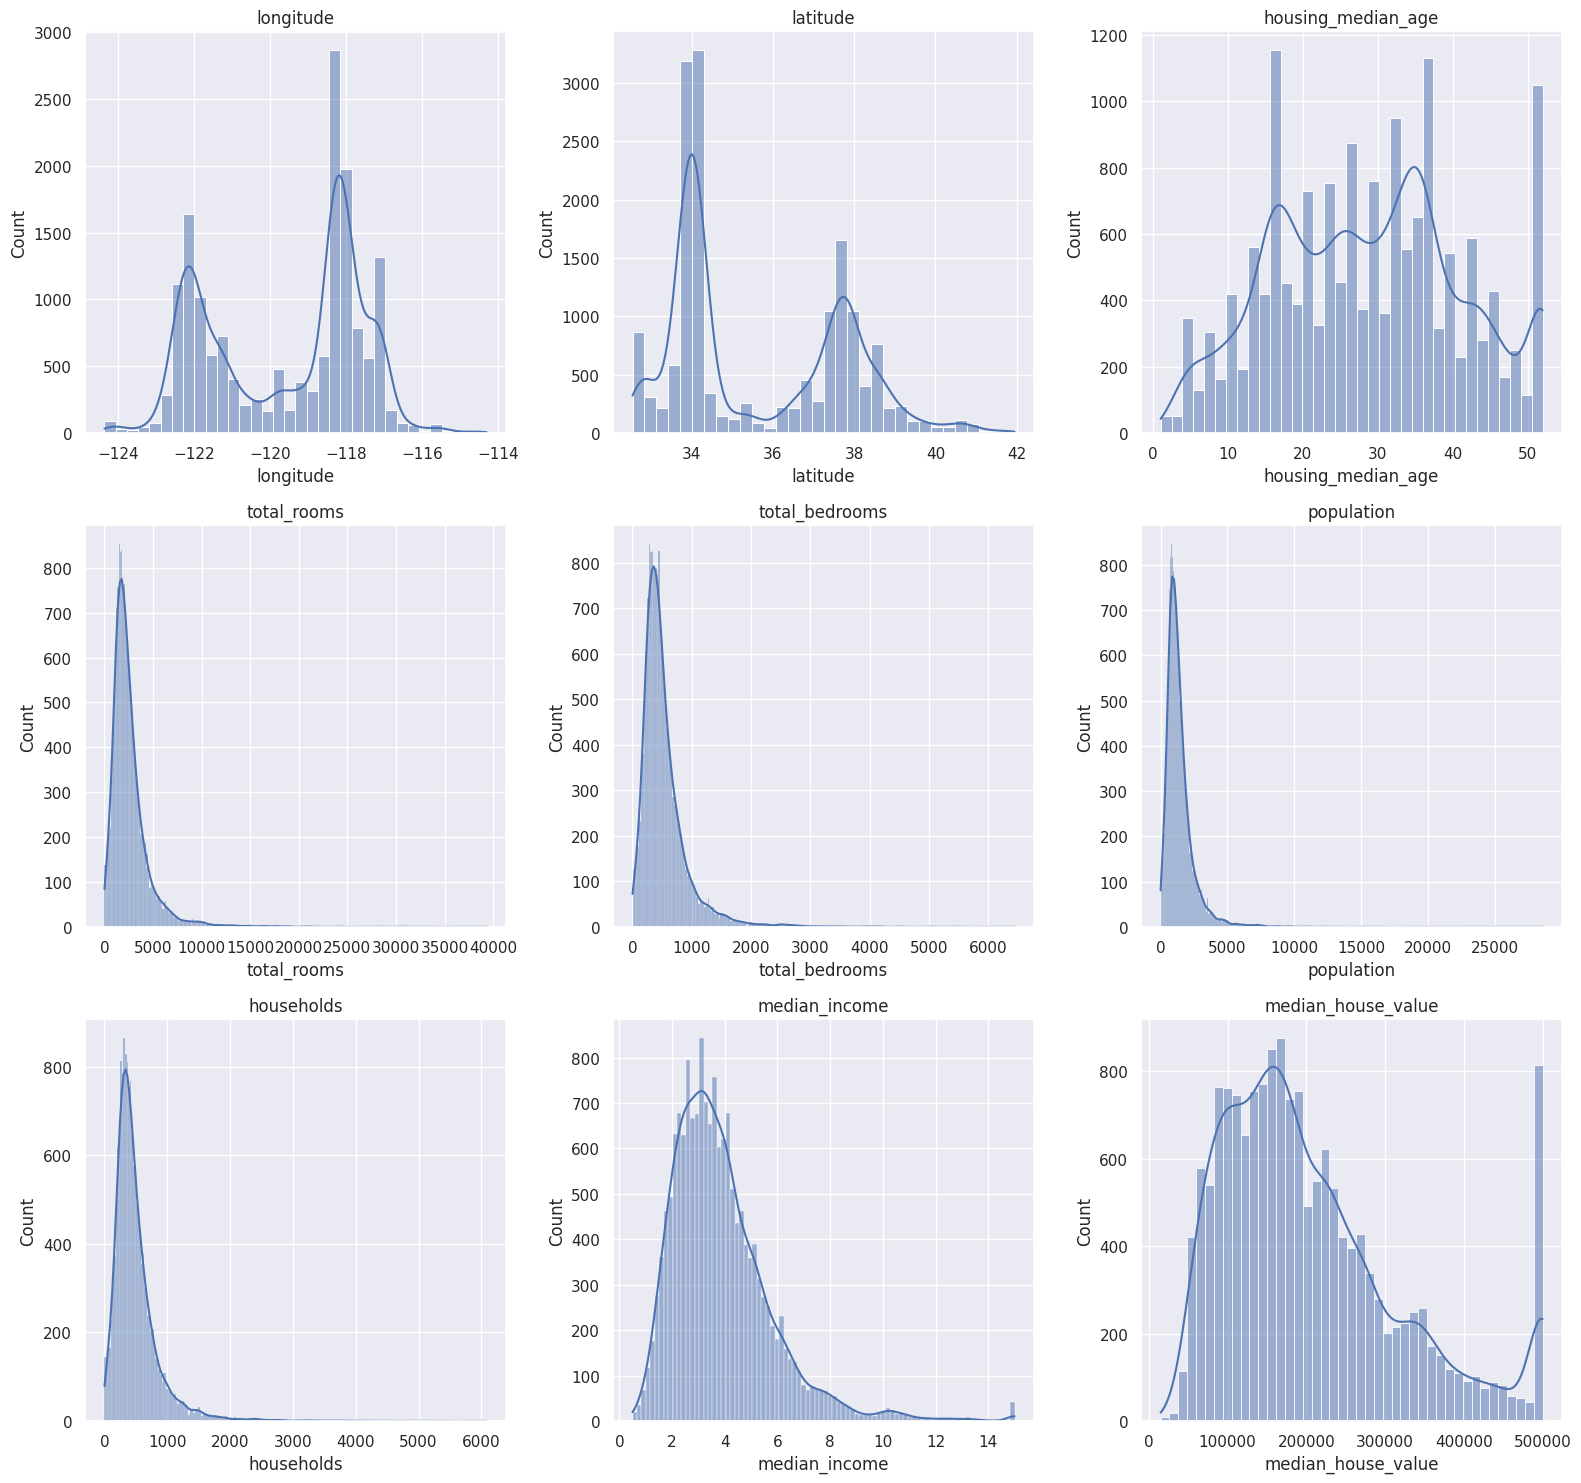

In [132]:
fig, ax = plt.subplots(3, 3, figsize=(16, 15))
axes = ax.flatten()

for i, col in enumerate(df.columns[:-5]):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

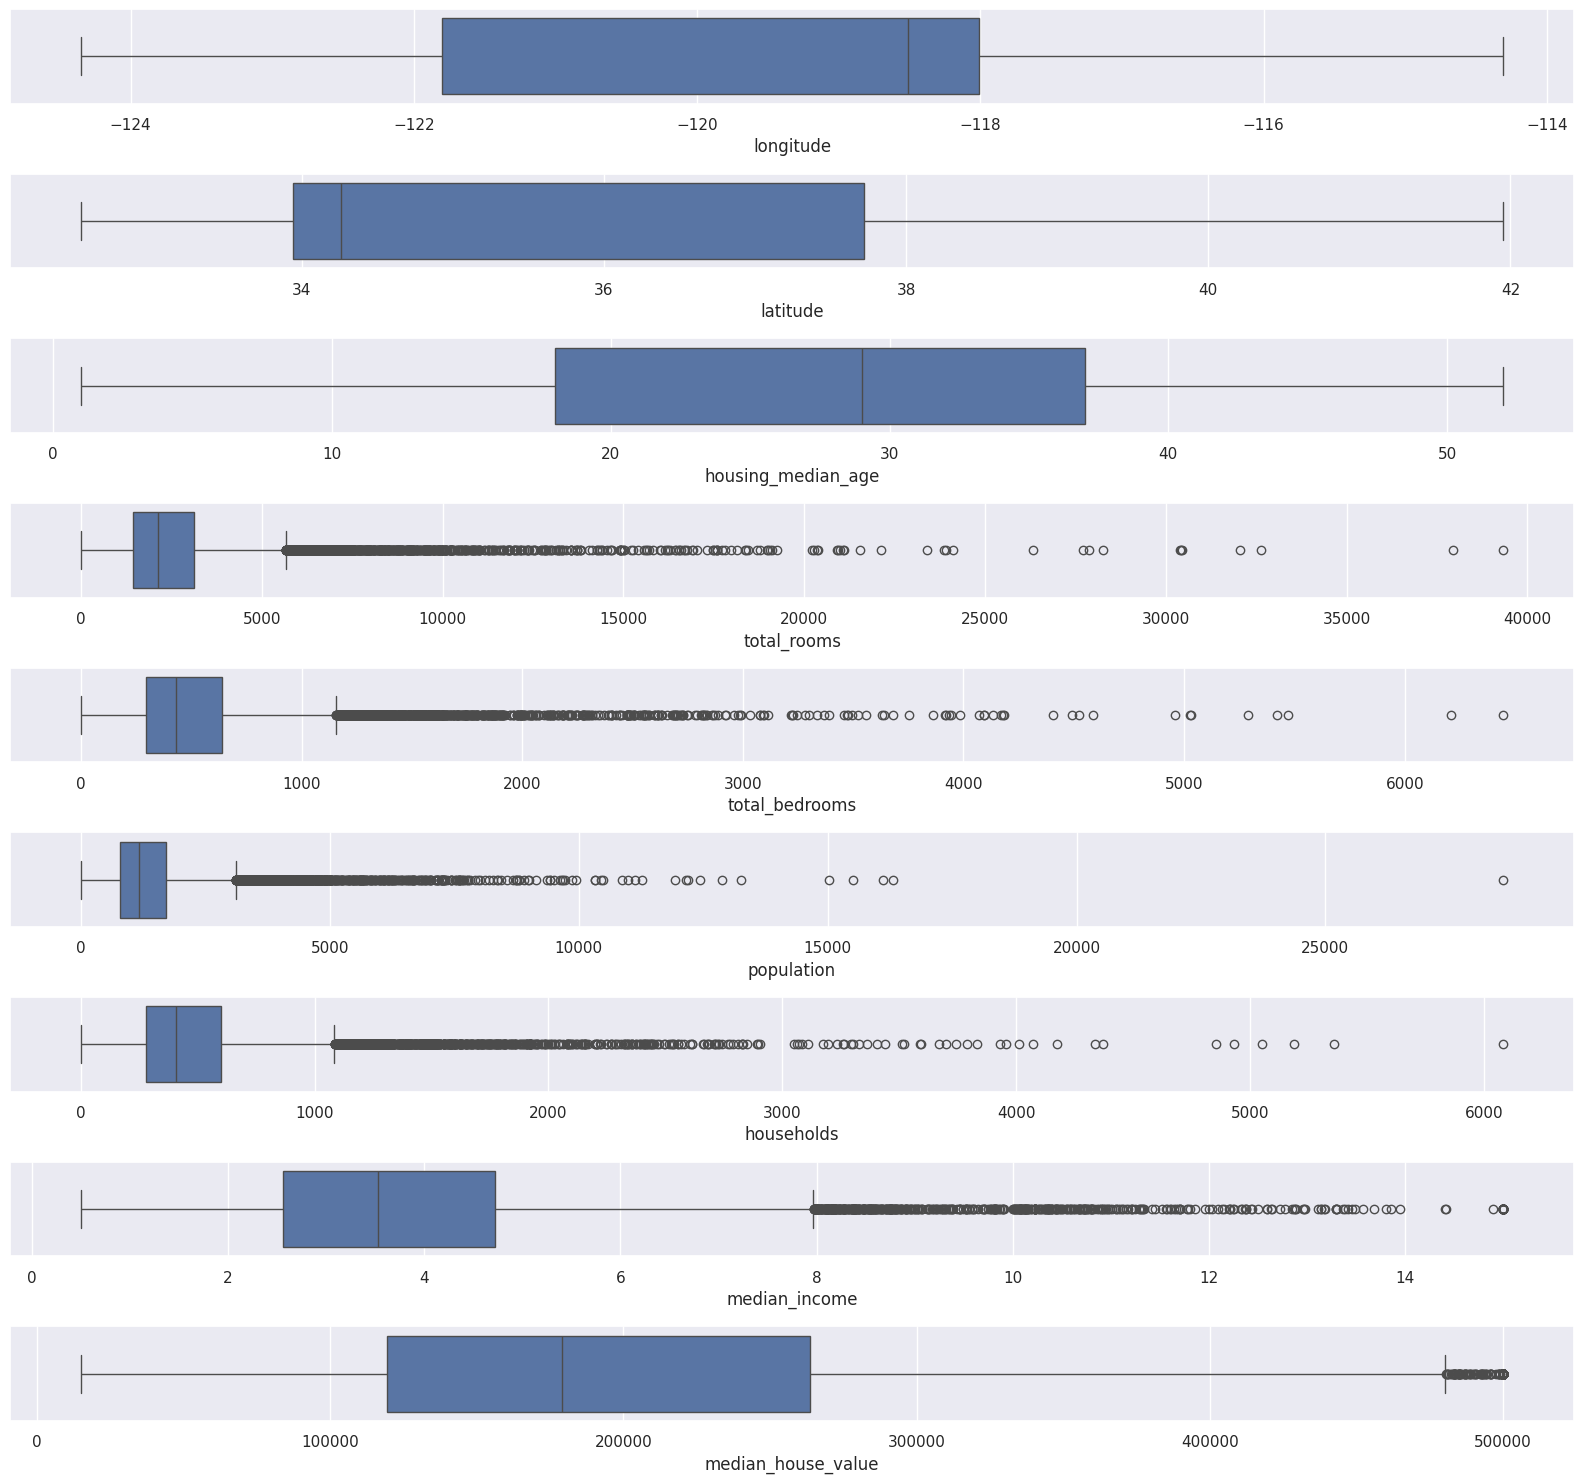

In [133]:
fig, ax = plt.subplots(len(df.columns[:-5]), 1, figsize=(16, 15))

for i, col in enumerate(df.columns[:-5]):
    sns.boxplot(data=df, x=col, ax=ax[i])

plt.tight_layout()
plt.show()

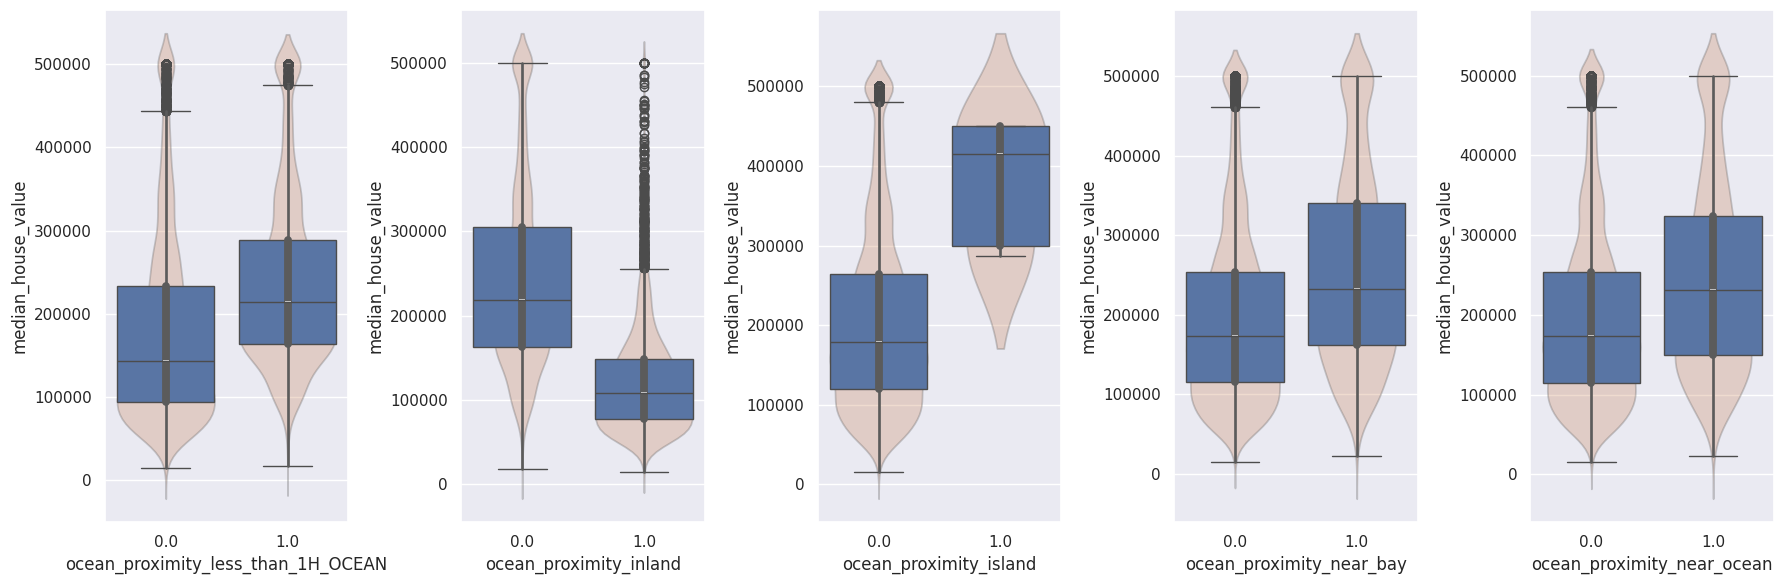

In [134]:
fig, ax = plt.subplots(1, len(df.columns[-5:]), figsize=(18, 6))

for i, col in enumerate(df.columns[-5:]):
    sns.boxplot(data=df, x=col, y='median_house_value', ax=ax[i])
    sns.violinplot(data=df, x=col, y='median_house_value', alpha=0.3, ax=ax[i])
plt.tight_layout()
plt.show()

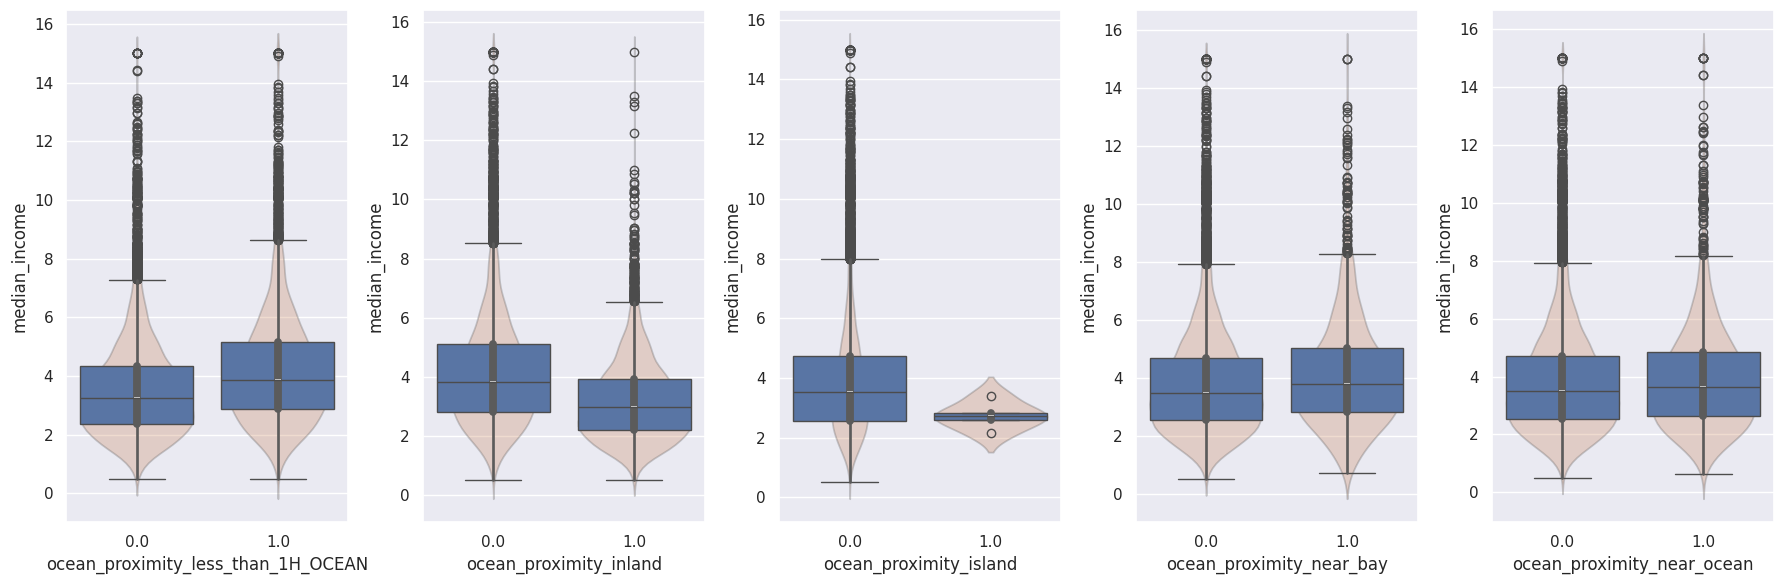

In [135]:
fig, ax = plt.subplots(1, len(df.columns[-5:]), figsize=(18, 6))

for i, col in enumerate(df.columns[-5:]):
    sns.boxplot(data=df, x=col, y='median_income', ax=ax[i])
    sns.violinplot(data=df, x=col, y='median_income', alpha=0.3, ax=ax[i])
plt.tight_layout()
plt.show()

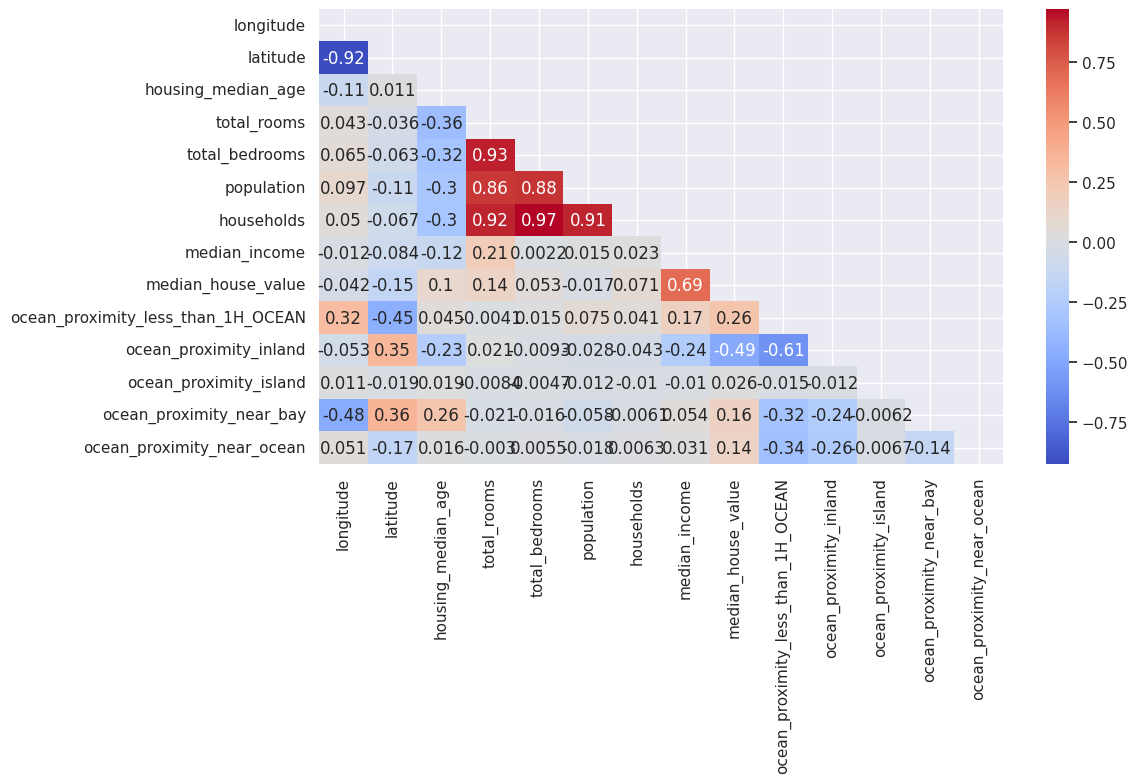

In [136]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=np.triu(corr))

plt.tight_layout()
plt.show()

In [137]:
corr.median_house_value.sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.691709
ocean_proximity_less_than_1H_OCEAN,0.256629
ocean_proximity_near_bay,0.158437
ocean_proximity_near_ocean,0.144377
total_rooms,0.139904
housing_median_age,0.102196
households,0.071154
total_bedrooms,0.053407
ocean_proximity_island,0.026379


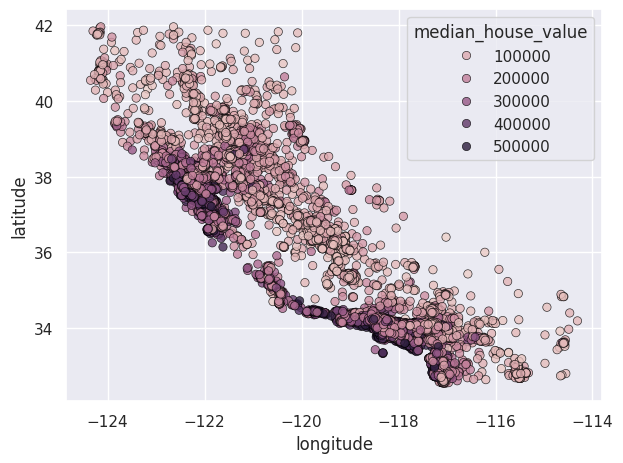

In [138]:
sns.scatterplot(data=df, x='longitude', y='latitude', hue='median_house_value', alpha=0.8, edgecolor='black')
plt.tight_layout()
plt.show()

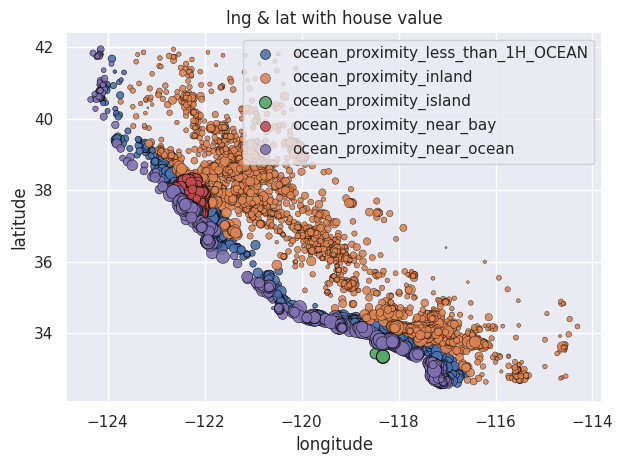

In [139]:
for i, col in enumerate(df.columns[-5:]):
    data = df[df[col] == 1]
    sns.scatterplot(x=data.longitude, y=data.latitude, alpha=0.9, edgecolor='black', s=data.median_house_value//5000, label=col)

plt.title('lng & lat with house value')
plt.legend()
plt.tight_layout()
plt.show()

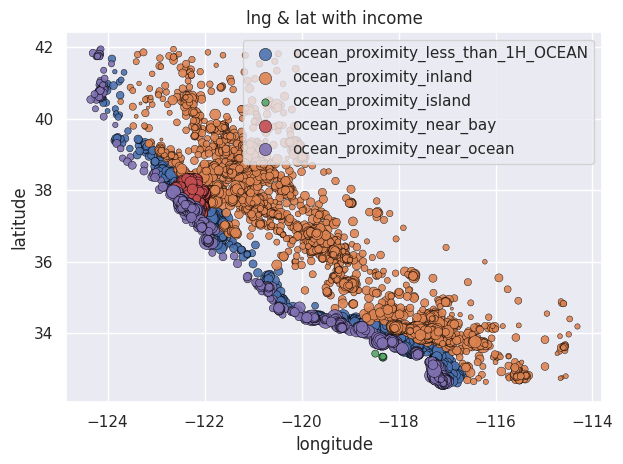

In [140]:
for i, col in enumerate(df.columns[-5:]):
    data = df[df[col] == 1]
    sns.scatterplot(x=data.longitude, y=data.latitude, alpha=0.9, edgecolor='black', s=data.median_income*10, label=col)

plt.title('lng & lat with income')
plt.legend()
plt.tight_layout()
plt.show()

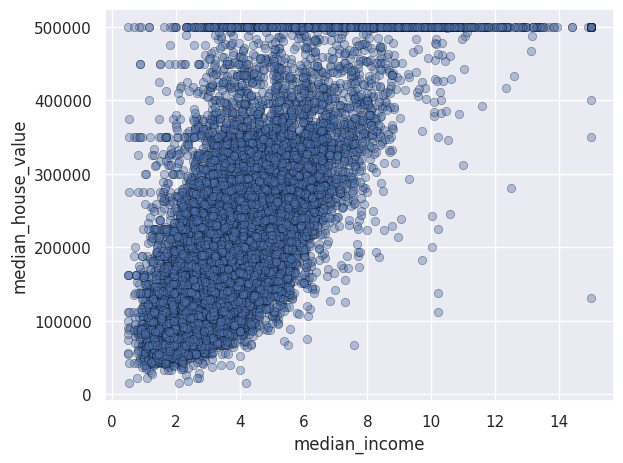

In [141]:
sns.scatterplot(data=df, x='median_income', y='median_house_value', alpha=0.4, edgecolor='black')
plt.tight_layout()
plt.show()

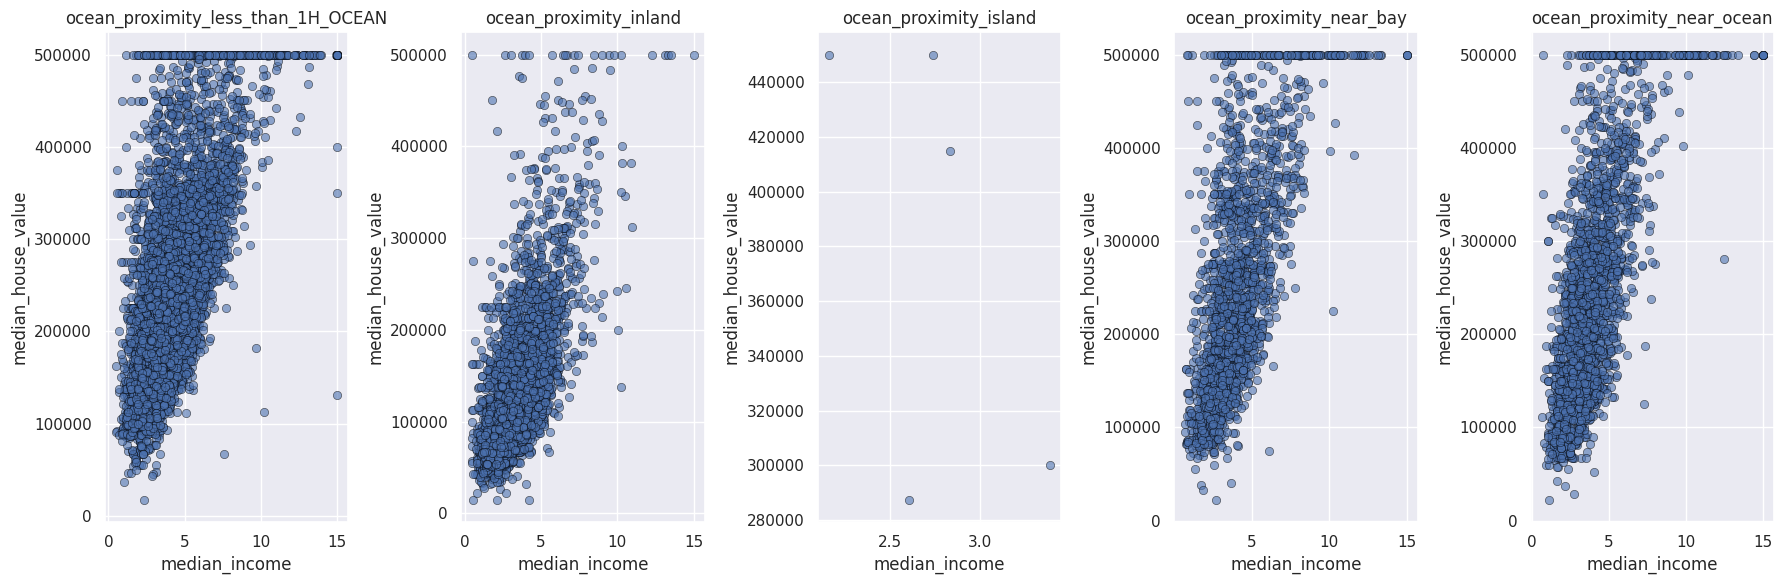

In [142]:
fig, ax = plt.subplots(1, len(df.columns[-5:]), figsize=(18, 6))

for i, col in enumerate(df.columns[-5:]):
    sns.scatterplot(data=df[df[col] == 1], x='median_income', y='median_house_value', ax=ax[i], edgecolor='black', alpha=0.6)
    ax[i].set_title(col)
plt.tight_layout()
plt.show()

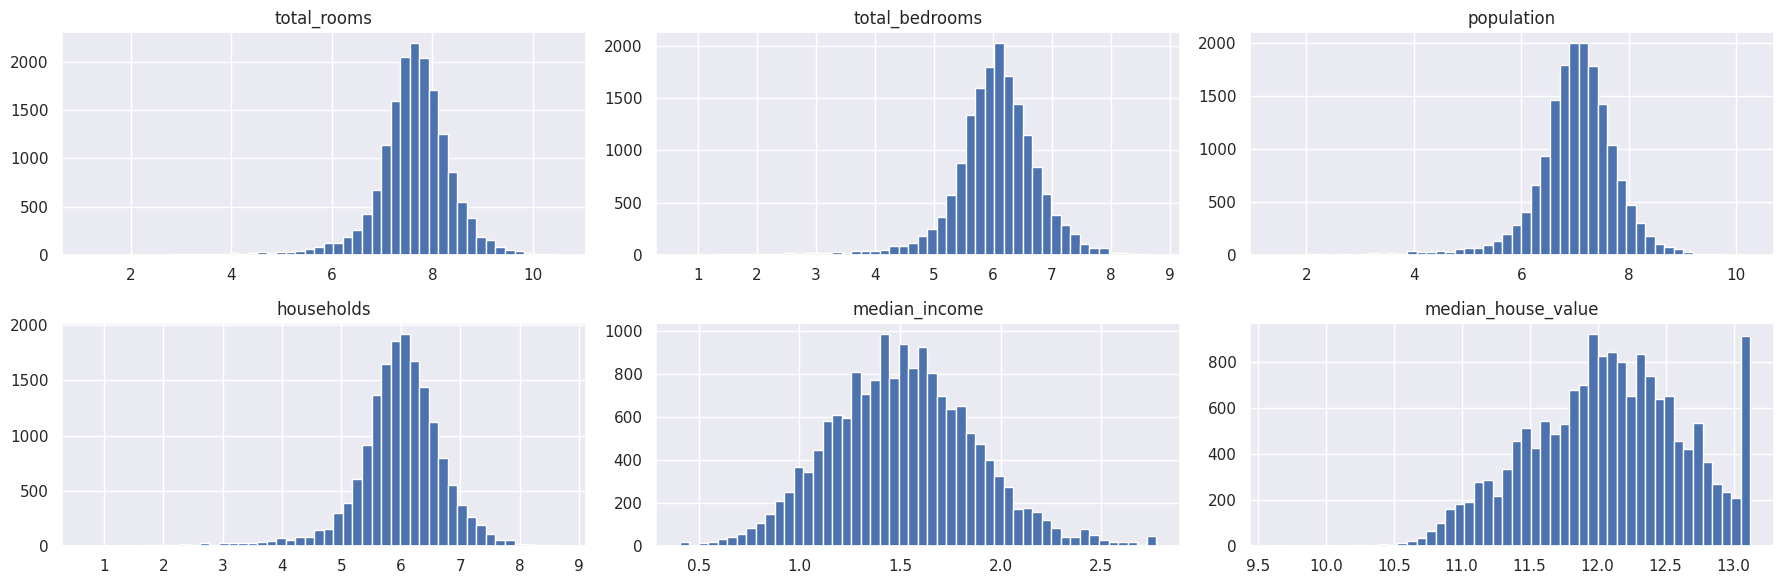

In [143]:
cols = df.columns[3:-5]
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
axes = ax.flatten()

for i, col in enumerate(cols):
    axes[i].hist(np.log(df[col] + 1), bins=50)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## **Outliers**

In [144]:
describe = np.log(df.iloc[:, 3:-5]).describe()
Q1 = describe.loc['25%']
Q3 = describe.loc['75%']
IQR = Q3 - Q1
lower_cap = Q1 - 1.5 * IQR
upper_cap = Q3 + 1.5 * IQR

outliers = (np.log(df.iloc[:, 3:-5]) < lower_cap) | (np.log(df.iloc[:, 3:-5]) > upper_cap)
(outliers.sum(1) > 0).sum() + (df.median_house_value < df.median_house_value.max()).sum()

np.int64(16911)

In [145]:
df = df[~(outliers.sum(1) > 0)]
df = df[df.median_house_value < df.median_house_value.max()]

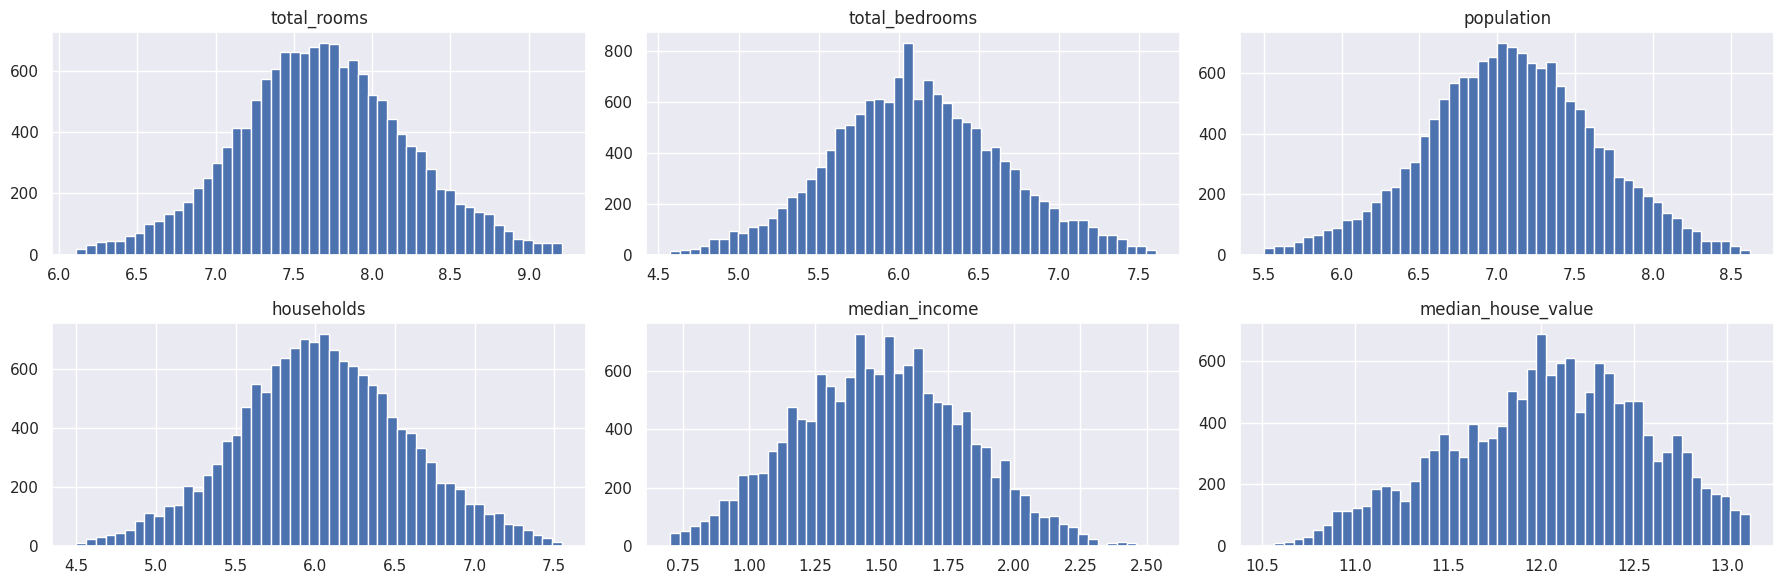

In [146]:
cols = df.columns[3:-5]
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
axes = ax.flatten()

for i, col in enumerate(cols):
    axes[i].hist(np.log(df[col] + 1), bins=50)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [147]:
cols = df.columns[-5:]
df[cols].sum()

,0
ocean_proximity_less_than_1H_OCEAN,6513.0
ocean_proximity_inland,4739.0
ocean_proximity_island,5.0
ocean_proximity_near_bay,1615.0
ocean_proximity_near_ocean,1843.0


In [148]:
df.drop(columns=['ocean_proximity_island'], inplace=True)
if 'ocean_proximity_island' in df_test.columns:
    df_test.drop(columns=['ocean_proximity_island'], inplace=True)

## **Feature Transform**

In [149]:
df.iloc[:, 3:-5] = df.iloc[:, 3:-5].apply(lambda x: np.log(x + 1))
df_test.iloc[:, 3:-5] = df_test.iloc[:, 3:-5].apply(lambda x: np.log(x + 1))

## **Standardization**

In [150]:
scaler = StandardScaler()

df.iloc[:, :-4] = scaler.fit_transform(df.iloc[:, :-4])
df_test.iloc[:, :-4] = scaler.transform(df_test.iloc[:, :-4])

## **Save**

In [151]:
X = df.drop(columns=['median_house_value']).values
y = df.median_house_value.values

np.save(x_train_file, X)
np.save(y_train_file, y)

X_test = df_test.drop(columns=['median_house_value']).values
y_test = df_test.median_house_value.values

np.save(x_train_file, X)
np.save(y_train_file, y)
np.save(x_test_file, X_test)
np.save(y_test_file, y_test)

# **Model**

In [152]:
X = np.load(x_train_file)
y = np.load(y_train_file)

## **Cross Validation**

In [153]:
model = SGDRegressor(random_state=42)

In [154]:
lrs = np.logspace(-3, 0, 50)
alphas = np.logspace(-6, 0, 50)
params_distribution = {
    'eta0': lrs,
    'alpha': alphas,
}

In [155]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params_distribution,
    n_iter=250,
    random_state=42,
)
random_search.fit(X, y)

random_search.best_params_, random_search.best_score_

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


({'eta0': np.float64(0.012648552168552958),
  'alpha': np.float64(2.3299518105153717e-06)},
 np.float64(0.6332571288206124))

In [156]:
lr, alpha = random_search.best_params_.values()
d1, d2 = 0.1, 0.1

lrs = np.r_[np.linspace(lr * (1 - d1), lr * (1 + d1), 50), lr]
alphas = np.r_[np.linspace(alpha * (1 - d2), alpha * (1 + d2), 50), alpha]
params_grid = {
    'eta0': lrs,
    'alpha': alphas,
}

In [157]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=params_grid,
)
grid_search.fit(X, y)

grid_search.best_params_, grid_search.best_score_

({'alpha': np.float64(2.0969566294638345e-06),
  'eta0': np.float64(0.013293886462866885)},
 np.float64(0.6332665591018769))

In [159]:
joblib.dump(grid_search.best_estimator_, model_file)

['/content/drive/MyDrive/model.pkl']

# **Test**

In [160]:
X_test = np.load(x_train_file)
y_test = np.load(y_train_file)
model = joblib.load(model_file)

In [161]:
model.score(X_test, y_test)

0.6330904426935402